# Assignment 2

In [2]:
import tensorflow as tf
#from scipy.io import loadmat

In [3]:
import struct

import numpy as np

def read_idx(filename):
    '''A function to read idx file format into numpy array'''
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
train_set = read_idx('train-images-idx3-ubyte.mat')
print(train_set.shape)
train_label = read_idx('train-labels-idx1-ubyte.mat')
train_label = np.expand_dims(train_label, axis=1)
print(train_label.shape)

test_set = read_idx('t10k-images-idx3-ubyte.mat')
print(test_set.shape)
test_label = read_idx('t10k-labels-idx1-ubyte.mat')
test_label = np.expand_dims(test_label, axis=1)
print(test_label.shape)
n_train = train_set.shape[0]
n_test = test_set.shape[0]


C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


(60000, 28, 28)
(60000, 1)
(10000, 28, 28)
(10000, 1)


In [4]:
#flatten the input to feed into MLP
train_set_flat = train_set.reshape((n_train, -1)) #reshape the data to n_train row, -1 is unspecified so that code decide on their own
test_set_flat = test_set.reshape((n_test, -1))

print(train_set_flat.shape)
print(test_set_flat.shape)

(60000, 784)
(10000, 784)


In [5]:
def one_hot(labels):
    """
    Encodes the labels as one-hot vectors. Zero is represented as 10 in SVHN.
    [10] -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    """
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

In [6]:
train_label_one_hot = one_hot(train_label)
test_label_one_hot = one_hot(test_label)


print(train_label_one_hot.shape)
print(test_label_one_hot.shape)

(60000, 10)
(10000, 10)


In [7]:
class SVHN_MLP:
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session() #open session which need to be closed later
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input') #placeholder with the correct dimension
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'): #different layers of the network
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1')
            print(h)
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='2')
            print(h)
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='3')
            print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='4')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'): #to compute the loss, reduce_mean return a scalar with mean of all the loss
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss) #minimise loss by updating variable using gradient update
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v) #tf.nn.12_loss return half of L2 norm without sqrt
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: ]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: ]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [8]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = SVHN_MLP(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [9]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

In [10]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set_flat, train_label_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.7304553985595703
Minibatch loss at step 50: 0.39563536643981934
Minibatch loss at step 100: 0.351732075214386
Minibatch loss at step 150: 0.3777186870574951
Minibatch loss at step 200: 0.27048343420028687
Minibatch loss at step 250: 0.36491915583610535
Minibatch loss at step 300: 0.3982906937599182
Minibatch loss at step 350: 0.5005738735198975
Minibatch loss at step 400: 0.47761404514312744
Minibatch loss at step 450: 0.37590351700782776
Minibatch loss at step 500: 0.38703733682632446
Minibatch loss at step 550: 0.30181095004081726
Minibatch loss at step 600: 0.35700705647468567
Minibatch loss at step 650: 0.3236424922943115
Minibatch loss at step 700: 0.3736081123352051
Minibatch loss at step 750: 0.3654343783855438
Minibatch loss at step 800: 0.4663165509700775
Minibatch loss at step 850: 0.24075743556022644
Minibatch loss at step 900: 0.418569415807724
Minibatch loss at step 950: 0.28495144844055176
Minibatch loss at step 1000: 0.266468524

Minibatch loss at step 8500: 0.18068408966064453
Minibatch loss at step 8550: 0.22701296210289001
Minibatch loss at step 8600: 0.2342423051595688
Minibatch loss at step 8650: 0.3159503638744354
Minibatch loss at step 8700: 0.2096594274044037
Minibatch loss at step 8750: 0.21111057698726654
Minibatch loss at step 8800: 0.26160043478012085
Minibatch loss at step 8850: 0.23394779860973358
Minibatch loss at step 8900: 0.16353467106819153
Minibatch loss at step 8950: 0.21759790182113647
Minibatch loss at step 9000: 0.26261886954307556
Minibatch loss at step 9050: 0.2367348074913025
Minibatch loss at step 9100: 0.26674243807792664
Minibatch loss at step 9150: 0.18066278100013733
Minibatch loss at step 9200: 0.2610207796096802
Minibatch loss at step 9250: 0.18312107026576996
Minibatch loss at step 9300: 0.3770485520362854
Minibatch loss at step 9350: 0.3286290764808655
Minibatch loss at step 9400: 0.21046575903892517
Minibatch loss at step 9450: 0.22581851482391357
Minibatch loss at step 9500

In [11]:
losses = np.array(losses)
print(losses.shape)

(200, 2)


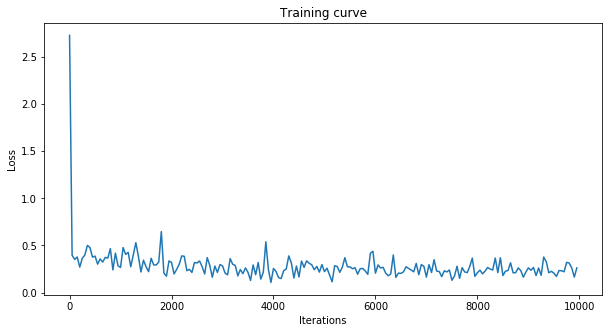

In [13]:
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [16]:
TEST_BATCH_SIZE = 128

model.test(test_set_flat, test_label_one_hot, TEST_BATCH_SIZE)

Average test loss: 0.24482792615890503


Test sample digit: 2


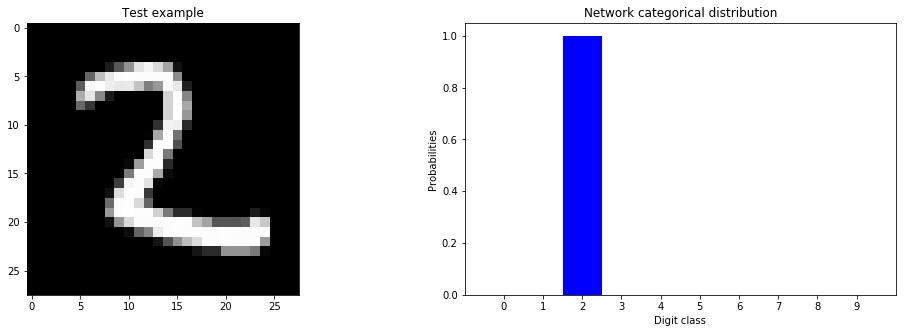

Network prediction probabilities:
[1.5608706e-05 1.5543711e-04 9.9960965e-01 1.5052586e-04 1.5607135e-08
 1.1248032e-05 1.6455842e-05 1.4783079e-06 3.9858420e-05 5.3380265e-09]


In [32]:
example = np.random.choice(np.arange(n_test)) #randomly choose a index from n_test

sample = np.expand_dims(test_set_flat[example], axis=0)
label = np.expand_dims(test_label_one_hot[example], axis=0)

digit = np.where(label[0]==1.0)[0][0] #extract the real digit, (index) from one_hot vector

feed_dict = {model.input: sample, model.ground_truth: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [33]:
train_time = end_time - start_time
print('total training time : {} s, or {} min {} s'.format(train_time, int(train_time/60), train_time%60))
count = len(tf.global_variables())
print('total parameters involved :', count)

total training time : 101.90418219566345 s, or 1 min 41.90418219566345 s
total parameters involved : 26


In [ ]:
model.sess.close()